In [1]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [2]:
def convert_dict_list_to_array(dictionary):
    for key, value in dictionary.items():
        dictionary[key] = np.asarray(value)

In [3]:
fname = "2020_11_12.hdf"
dset_name = "1605211414 J1 J2 microwave power scan"

devices = ()

In [4]:
pmt_channel = 1
shutter_channel = 2

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dset_name, devices)

In [5]:
microwave_powers_data = {}
attr_name = 'SynthHD Pro SetPower'
for idx in range(1,len(pxie)+1):
    microwave_powers_data[float(pxie_attrs[idx][attr_name])] = {'open': [], 'closed': []}

In [6]:
for idx in range(1,len(pxie)+1):
    μpower = float(pxie_attrs[idx][attr_name])
    
    traces = pxie[idx].copy()
    pmt = -traces[:,pmt_channel].astype(float)
    pmt -= np.mean(pmt[150:250])
    shutter_state = traces[:,shutter_channel].mean() > 2e4
    if shutter_state:
        microwave_powers_data[μpower]['open'].append(pmt)
    else:
        microwave_powers_data[μpower]['closed'].append(pmt)

In [7]:
list(microwave_powers_data.keys())

[-17.82, -16.9, -15.59, -14.59, -13.68, -11.0]

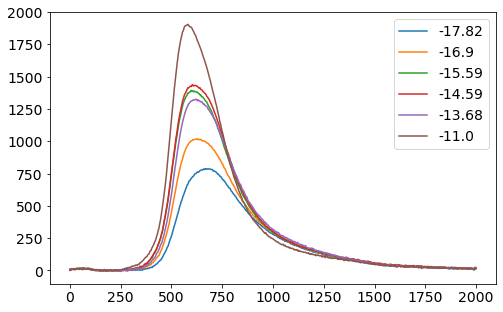

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
for p in list(microwave_powers_data.keys()):
    ax.plot(np.mean(microwave_powers_data[p]['open'], axis = 0), label = p)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

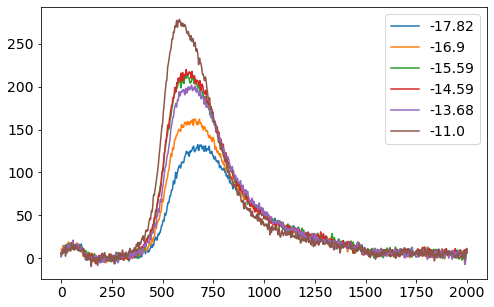

In [9]:
fig, ax = plt.subplots(figsize = (8,5))
for p in list(microwave_powers_data.keys()):
    ax.plot(np.mean(microwave_powers_data[p]['closed'], axis = 0), label = p)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [10]:
for p in list(microwave_powers_data.keys()):
    mo = np.mean(microwave_powers_data[p]['open'], axis = 0)
    mc = np.mean(microwave_powers_data[p]['closed'], axis = 0)
    io = np.trapz(mo[200:])
    ic = np.trapz(mc[200:])
    print(f'{p:.2f} A -> {io/ic:.3f} ratio')

-17.82 A -> 5.737 ratio
-16.90 A -> 6.125 ratio
-15.59 A -> 6.312 ratio
-14.59 A -> 6.407 ratio
-13.68 A -> 6.391 ratio
-11.00 A -> 6.579 ratio


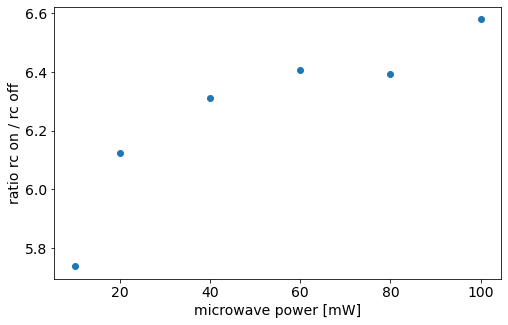

In [19]:
dBm_to_mW = {-17.82: 10, -16.9: 20, -15.59: 40,
             -14.59: 60, -13.68: 80, -11.0: 100}

fig, ax = plt.subplots(figsize = (8,5))

for p in list(microwave_powers_data.keys()):
    mo = np.mean(microwave_powers_data[p]['open'], axis = 0)
    mc = np.mean(microwave_powers_data[p]['closed'], axis = 0)
    io = np.trapz(mo[200:])
    ic = np.trapz(mc[200:])
    ax.plot(dBm_to_mW[p], io/ic, '.', ms = 12, color = 'C0')
    
ax.set_xlabel('microwave power [mW]')
ax.set_ylabel('ratio rc on / rc off')
set_fontsize(ax, 14)